In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import csv
import json
import gym
import time
import datetime
import torch
import numpy as np
import subprocess

import babyai
import babyai.utils as utils
import babyai.rl
from babyai.arguments import ArgumentParser
from babyai.model import SpeakerModel, ListenerModel
from babyai.evaluate import batch_evaluate
from babyai.utils.agent import ModelAgent
from babyai.rl.utils import DictList, ParallelEnv

import seaborn as sns
import pandas as pd
from numpy import dot
from numpy.linalg import norm
from scipy.stats import spearmanr
from torch import nn
from torch import optim

In [186]:
args = {
    'seed': 42,
    'procs': 2,
    'env': "BabyAI-GoToLocal-v0",
    'instr_arch': 'gru',
    'no_mem': False,
    'algo': 'ppo_reinforce',
    'arch': 'expert_filmcnn',
    'pretrained_model': "BabyAI-GoToLocal-v0_V50_L10",
    'model': None,
    'image_dim': 128,
    'memory_dim': 128,
    'instr_dim': 128,
    'no_instr': False,
    'vocab_size': 50,
    'max_len': 10,
}

utils.seed(args['seed'])

## Setup

#### Create environmnet

In [187]:
# check environment names
env_names = args['env'].split("_")
env_num = len(env_names)
# Generate environments
envs = []
for i in range(args['procs']):
    env = gym.make(env_names[i // (args['procs']//env_num)])
    env = utils.FullyObsWrapper(env)
    env.seed(100 * args['seed'] + i)
    envs.append(env)

In [188]:
envs[0]

<FullyObsWrapperWGWGWGWGWGWGWGWG
WG  AR  AG    WG
WGKP          WG
WG            WG
WG^^    KYKG  WG
WG          AYWG
WG    BY  AY  WG
WGWGWGWGWGWGWGWG>

#### Define model name

In [189]:
suffix = datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")
instr = args['instr_arch'] if args['instr_arch'] else "noinstr"
mem = "mem" if not args['no_mem'] else "nomem"
model_name_parts = {
    'env': args['env'],
    'algo': args['algo'],
    'arch': args['arch'],
    'instr': instr,
    'mem': mem,
    'seed': args['seed'],
    'info': '',
    'coef': '',
    'suffix': suffix,
    'vocab_size': args['vocab_size'],
    'max_len': args['max_len']
}
default_model_name = "{env}_{algo}_{arch}_{instr}_{mem}_seed{seed}{info}{coef}_V{vocab_size}_L{max_len}_{suffix}".format(**model_name_parts)
if args['pretrained_model']:
    default_model_name = default_model_name + '_PretrainedWith_' + args['pretrained_model']
args['model'] = args['model'].format(**model_name_parts) if args['model'] else default_model_name

In [190]:
args['model']

'BabyAI-GoToLocal-v0_ppo_reinforce_expert_filmcnn_gru_mem_seed42_V50_L10_20-11-04-23-48-33_PretrainedWith_BabyAI-GoToLocal-v0_V50_L10'

#### Define obss preprocessor

In [191]:
speaker_obss_preprocessor = utils.SpeakerObssPreprocessor(args['model'])

In [192]:
speaker_obss_preprocessor

#### Define model

In [193]:
speaker, _ = utils.load_ec_model(args['pretrained_model'], raise_not_found=True)
speaker.training = False

if torch.cuda.is_available():
    speaker.cuda()

In [194]:
speaker

SpeakerModel(
  (image_conv): None
  (film_pool): None
  (instr_cnn): Sequential(
    (0): Conv2d(21, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (8): ReLU()
    (9): Flatten()
    (10): Linear(in_features=128, out_features=128, bias=True)
  )
  (instr_rnn): GRU(128, 128, batch_first=True)
  (FiLM_Controler_0): None
  (FiLM_Controler_1): None
  (actor): None
  (critic): None
  (instr_gru): ModuleList(
    (0): GRUCell(128, 128)
    (1): GRUCell(128, 128)
  )
  (hidden_to_output): Linear(in_features=128, out_features=50, bias=True)
  (vocab_embedding): Embedding(50, 128)
)

#### Experiment Flow

In [195]:
penv = ParallelEnv(envs)

In [196]:
%%time

mission_to_message = {}
embedding_to_message = []

for i in range(1000):
    # observation
    obs = penv.reset()
    # preprocessed obs
    s_obs = speaker_obss_preprocessor(obs, device='cuda')
    # forward to speaker
    memory = torch.zeros(args['procs'], speaker.memory_size, device='cuda')
    mask = torch.ones(args['procs'], device='cuda')
    with torch.no_grad():
        model_results = speaker(s_obs, memory * mask.unsqueeze(1))
        message = model_results['value'].cpu().numpy()
        embedding = model_results['extra_predictions']['embedding'].cpu().numpy()
    
    # embedding - message pairs
    for emb, mes in zip(embedding, message):
        embedding_to_message.append((emb, mes))

    # instruction - message
    for i, o in enumerate(obs):
        if o['mission'] not in mission_to_message.keys():
            mission_to_message[o['mission']] = []
        rand_message = [np.random.randint(0, args["vocab_size"]) for _ in range(args["max_len"])]
        mission_to_message[o['mission']].append(rand_message)
#         mission_to_message[o['mission']].append(message[i])

Wall time: 17 s


In [197]:
mission_to_message

{'go to the green ball': [[28, 14, 42, 7, 20, 38, 18, 22, 10, 10],
  [32, 20, 31, 22, 32, 2, 17, 24, 41, 30],
  [31, 22, 21, 24, 21, 21, 48, 41, 5, 14],
  [46, 33, 31, 47, 24, 39, 44, 0, 15, 38],
  [8, 23, 34, 48, 34, 47, 35, 17, 48, 38],
  [41, 38, 13, 30, 4, 34, 22, 28, 42, 10],
  [32, 23, 14, 29, 41, 16, 4, 28, 3, 9],
  [12, 39, 17, 24, 32, 46, 39, 42, 11, 43],
  [48, 28, 42, 21, 25, 27, 49, 20, 48, 6],
  [29, 37, 3, 0, 7, 28, 38, 2, 31, 9],
  [17, 45, 46, 30, 37, 31, 10, 44, 24, 32],
  [35, 44, 7, 28, 31, 43, 17, 5, 17, 18],
  [49, 22, 43, 37, 19, 22, 44, 15, 49, 41],
  [43, 33, 32, 20, 16, 21, 47, 36, 14, 34],
  [18, 33, 9, 24, 1, 10, 49, 30, 14, 8],
  [4, 19, 20, 39, 30, 45, 35, 10, 14, 18],
  [20, 34, 31, 29, 38, 48, 11, 40, 46, 17],
  [44, 19, 16, 6, 3, 28, 13, 2, 23, 36],
  [23, 13, 25, 37, 22, 21, 47, 18, 45, 2],
  [11, 34, 42, 0, 44, 14, 25, 36, 20, 48],
  [10, 14, 31, 27, 21, 40, 16, 25, 43, 6],
  [26, 39, 35, 33, 28, 23, 23, 41, 3, 2],
  [35, 41, 36, 21, 41, 11, 41, 12, 10

In [198]:
embedding_to_message

[(array([ 0.06879319,  0.5674333 , -0.09274019, -0.23785204,  0.22485243,
         -0.7886764 ,  0.07469666,  0.7280723 , -0.07374983, -0.56403476,
          0.9578366 ,  0.10505804,  0.388515  ,  0.0032378 , -0.567978  ,
         -0.18509302, -0.8446509 , -0.8847393 ,  0.76971674, -0.9546072 ,
         -0.28606302,  0.4580543 , -0.2695844 , -0.98732793,  0.00469346,
         -0.02826684,  0.85926276,  0.2651261 ,  0.81942433, -0.04377019,
         -0.6203668 , -0.12602852, -0.24278018, -0.83229184, -0.62286943,
          0.4842486 ,  0.07559235,  0.9470285 , -0.79845786,  0.86004734,
          0.77036756,  0.07932061, -0.8623504 ,  0.1363107 ,  0.32294005,
         -0.87826884, -0.95226353,  0.73920214,  0.7505895 ,  0.95340604,
         -0.01568499,  0.0486109 , -0.5277214 , -0.7314616 , -0.34759545,
         -0.25617847,  0.35865578, -0.71527517, -0.23691687, -0.0675312 ,
         -0.2702306 ,  0.27514383, -0.58803195,  0.45117587,  0.70657367,
         -0.90493596,  0.147445  , -0.

## Mapping Correlations

### Calculate Word/Symbol distances

In [99]:
def calculate_word_distance(s1, s2, stopwords):
    '''calculate # of word differences between two strings'''
    # convert to set
    s1 = set(s1.split())
    s2 = set(s2.split())
    
    # remove stopwords
    for word in stopwords:
        s1.discard(word)
        s2.discard(word)
    
    return max(len(s1-s2), len(s2-s1))

def calculate_symbol_distance(l1, l2):
    distance = 0
    for (sym1, sym2) in zip(l1, l2):
        if sym1 != sym2:
            distance += 1
    return distance

In [100]:
%%time
visited_mission_pairs = set()
word_distances = []
symbol_distances = []

stopwords = set(['a', 'the'])

for mission1, symbols1 in mission_to_message.items():
    for mission2, symbols2 in mission_to_message.items():
        if (mission1, mission2) in visited_mission_pairs:
            continue
        # add mission pair
        visited_mission_pairs.add((mission1, mission2))
        # add word distance
        word_distances.append(calculate_word_distance(mission1, mission2, stopwords))
        # add average symbol distance
        symbol_distance = 0
        for sym1 in symbols1:
            for sym2 in symbols2:
                symbol_distance += calculate_symbol_distance(sym1, sym2)
        symbol_distance /= len(symbols1) * len(symbols2)
        symbol_distances.append(symbol_distance)

Wall time: 8.34 s


#### Add result to dictionary

In [18]:
data = {
    'Group': [],
    'Word Distance': [],
    'Symbol Distance': [],
}

In [19]:
group = 'V5'
for word_dist, symbol_dist in zip(word_distances, symbol_distances):
    data['Group'].append(group)
    data['Word Distance'].append(word_dist)
    data['Symbol Distance'].append(symbol_dist)
spearmanr(word_distances, symbol_distances)

SpearmanrResult(correlation=0.29914954990882053, pvalue=3.3398694080253007e-28)

In [47]:
group = 'V10'
for word_dist, symbol_dist in zip(word_distances, symbol_distances):
    data['Group'].append(group)
    data['Word Distance'].append(word_dist)
    data['Symbol Distance'].append(symbol_dist)
spearmanr(word_distances, symbol_distances)

SpearmanrResult(correlation=0.7037998760733808, pvalue=2.1956821099230118e-194)

In [74]:
group = 'V20'
for word_dist, symbol_dist in zip(word_distances, symbol_distances):
    data['Group'].append(group)
    data['Word Distance'].append(word_dist)
    data['Symbol Distance'].append(symbol_dist)
spearmanr(word_distances, symbol_distances)

SpearmanrResult(correlation=0.5930571517585115, pvalue=6.081178389225667e-124)

In [101]:
group = 'V50'
for word_dist, symbol_dist in zip(word_distances, symbol_distances):
    data['Group'].append(group)
    data['Word Distance'].append(word_dist)
    data['Symbol Distance'].append(symbol_dist)
spearmanr(word_distances, symbol_distances)

SpearmanrResult(correlation=0.3528728520229661, pvalue=2.6884186779685983e-39)

In [102]:
# random word distance
vocab = 10
random_dist = []
for _ in range(len(word_distances)):
    i = np.random.randint(0, vocab, 10)
    j = np.random.randint(0, vocab, 10)
    random_dist.append(calculate_symbol_distance(i, j))

In [103]:
group = 'Rand'
for word_dist, rand_dist in zip(word_distances, random_dist):
    data['Group'].append(group)
    data['Word Distance'].append(word_dist)
    data['Symbol Distance'].append(rand_dist)
spearmanr(word_distances, random_dist)

SpearmanrResult(correlation=0.044307369728972104, pvalue=0.11086681155079271)

#### Boxplot

In [104]:
df = pd.DataFrame(data=data)
df.head()

,Group,Word Distance,Symbol Distance
0,V5,0,0.000000
1,V5,2,1.000000
2,V5,1,1.670588
3,V5,2,7.121212
4,V5,1,7.022222


In [105]:
# df.to_csv("report/GoToLocal_L10-Boxplot.csv", index=False)

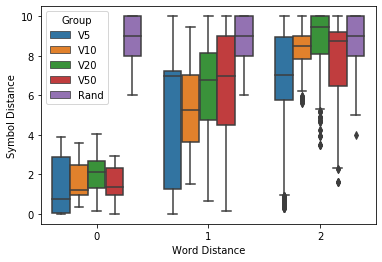

In [106]:
# sns_boxplot = sns.boxplot(x='Word Distance', y='Symbol Distance', data=df, hue='Group')
# fig = sns_boxplot.get_figure()
# fig.savefig("report/GoToLocal_L10-Boxplot+Random.png")

### Calculate embeddings' similarity

In [107]:
def calculate_cosing_similarity(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))

In [108]:
%%time
cos_sim = []
cos_sym_dist = []
for i, (v1, m1) in enumerate(embedding_to_message):
    for j, (v2, m2) in enumerate(embedding_to_message):
        if i==j: continue
        cos_sim.append(calculate_cosing_similarity(v1, v2))
        cos_sym_dist.append(calculate_symbol_distance(m1, m2))
cos_sim = np.array(cos_sim)
cos_sym_dist = np.array(cos_sym_dist)

Wall time: 38.8 s


#### Add result to dictionary

In [22]:
data_ = {
    'Group': [],
    'Cosine Similarity': [],
    'Symbol Distance': [],
}

In [23]:
group = 'V5'
for cs, csd in zip(cos_sim, cos_sym_dist):
    data_['Group'].append(group)
    data_['Cosine Similarity'].append(cs)
    data_['Symbol Distance'].append(csd)
spearmanr(cos_sym_dist, cos_sim)

SpearmanrResult(correlation=-0.49076101261825694, pvalue=0.0)

In [50]:
group = 'V10'
for cs, csd in zip(cos_sim, cos_sym_dist):
    data_['Group'].append(group)
    data_['Cosine Similarity'].append(cs)
    data_['Symbol Distance'].append(csd)
spearmanr(cos_sym_dist, cos_sim)

SpearmanrResult(correlation=-0.5901388968098532, pvalue=0.0)

In [77]:
group = 'V20'
for cs, csd in zip(cos_sim, cos_sym_dist):
    data_['Group'].append(group)
    data_['Cosine Similarity'].append(cs)
    data_['Symbol Distance'].append(csd)
spearmanr(cos_sym_dist, cos_sim)

SpearmanrResult(correlation=-0.6847107894556839, pvalue=0.0)

In [109]:
group = 'V50'
for cs, csd in zip(cos_sim, cos_sym_dist):
    data_['Group'].append(group)
    data_['Cosine Similarity'].append(cs)
    data_['Symbol Distance'].append(csd)
spearmanr(cos_sym_dist, cos_sim)

SpearmanrResult(correlation=-0.7700431459517905, pvalue=0.0)

In [110]:
# random word distance
vocab = 10
random_dist = []
for _ in range(len(cos_sim)):
    i = np.random.randint(0, vocab, 10)
    j = np.random.randint(0, vocab, 10)
    random_dist.append(calculate_symbol_distance(i, j))

In [111]:
group = 'Rand'
for cs, rand_dist in zip(cos_sim, random_dist):
    data_['Group'].append(group)
    data_['Cosine Similarity'].append(cs)
    data_['Symbol Distance'].append(rand_dist)
spearmanr(cos_sim, random_dist)

SpearmanrResult(correlation=4.6224028252826704e-05, pvalue=0.9263604466244992)

#### Boxplot

In [112]:
df_ = pd.DataFrame(data=data_)
df_.head()

,Group,Cosine Similarity,Symbol Distance
0,V5,0.963738,1
1,V5,0.930994,2
2,V5,0.751649,8
3,V5,0.763916,7
4,V5,0.979113,10


In [113]:
# df_.to_csv("report/GoToLocal_L10-CosSimBoxplot.csv", index=False)

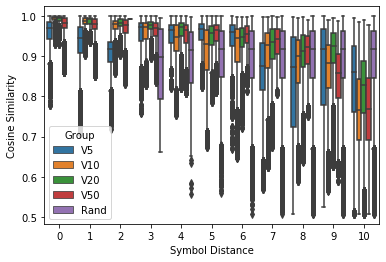

In [114]:
# sns_boxplot = sns.boxplot(x='Symbol Distance', y='Cosine Similarity', data=df_, hue='Group')
# fig = sns_boxplot.get_figure()
# fig.savefig("report/GoToLocal_L10-CosSimBoxplot+Random.png")

## TRE

#### Retrieve reps/exprs

In [199]:
derivations = {
    'blue': 0,
    'green': 1,
    'grey': 2,
    'purple': 3,
    'red': 4,
    'yellow': 5,
    'ball': 6,
    'key': 7,
    'box': 8
}

In [200]:
def derivations_extract(mission):
    global derivations
    r = []
    for word in mission.split():
        d = derivations.get(word, None)
        if d is not None:
            r.append(torch.tensor(d).unsqueeze(dim=0))
    return (r[0], r[1])

In [201]:
def representation_extract(message):
    N_VOCAB = args['vocab_size'] 
    MSG_LEN = args['max_len']
    repr = np.zeros(N_VOCAB * MSG_LEN)
    for index, symbol in enumerate(message):
        repr[symbol * MSG_LEN + index] = 1
    return torch.FloatTensor(repr)

In [202]:
%%time
reprs = []
exprs = []
for mission in mission_to_message.keys():
    for message in mission_to_message[mission]:
        reprs.append(representation_extract(message))
        exprs.append(derivations_extract(mission))

Wall time: 69 ms


#### Fit

In [203]:
class L1Dist(nn.Module):
    def forward(self, pred, target):
        return torch.abs(pred - target).sum()


class Objective(nn.Module):
    def __init__(self, vocab, repr_size, comp_fn, err_fn, zero_init):
        super().__init__()
        self.emb = nn.Embedding(len(vocab), repr_size)
        if zero_init:
            self.emb.weight.data.zero_()
        self.comp = comp_fn
        self.err = err_fn

    def compose(self, e):
        if isinstance(e, tuple):
            args = (self.compose(ee) for ee in e)
            return self.comp(*args)
        return self.emb(e)

    def forward(self, rep, expr):
        return self.err(self.compose(expr), rep)


class Compose(nn.Module):
    def __init__(self):
        super().__init__()
        self.lproj = nn.Linear(args['max_len'], args['max_len'])
        self.rproj = nn.Linear(args['max_len'], args['max_len'])
        
    def forward(self, x, y):
        x = x.view(1, args['vocab_size'], args['max_len'])
        y = y.view(1, args['vocab_size'], args['max_len'])
        xproj = self.lproj(x)
        yproj = self.rproj(y)
        return (xproj + yproj).view(1, args['vocab_size'] * args['max_len'])

In [204]:
COMP_FN = Compose()
ERR_FN = L1Dist()
obj = Objective(derivations.keys(), reprs[0].size()[0], COMP_FN, ERR_FN, True)
opt = optim.RMSprop(obj.parameters(), lr=1e-3)

In [205]:
steps = 1000
for t in range(steps):
    opt.zero_grad()
    errs = [obj(r, e) for r, e in zip(reprs, exprs)]
    loss = sum(errs)
    loss.backward()
    if t % 10 == 0:
        print(t, loss.item()/len(errs))
    opt.step()

final_errs = [err.item() for err in errs]
print(f"TRE: {np.mean(final_errs)}")

0 112.5903203125
10 44.47378515625
20 18.1965390625
30 12.904482421875
40 12.6311318359375
50 12.5570107421875
60 12.4758544921875
70 12.3539345703125
80 12.3479794921875
90 12.2576015625
100 12.2015126953125
110 12.15694921875
120 12.0724580078125
130 12.04490625
140 11.9944619140625
150 11.99537109375
160 11.9418623046875
170 11.9351396484375
180 11.8801123046875
190 11.9109091796875
200 11.845818359375
210 11.8451064453125
220 11.83104296875
230 11.8090224609375
240 11.7644375
250 11.7913349609375
260 11.7947138671875
270 11.80516015625
280 11.7856318359375
290 11.786076171875
300 11.7826376953125
310 11.7358369140625
320 11.772115234375
330 11.699259765625
340 11.757857421875
350 11.7249169921875
360 11.7042001953125
370 11.6567041015625
380 11.7316015625
390 11.70657421875
400 11.743369140625
410 11.7358759765625
420 11.7115869140625
430 11.7231220703125
440 11.6963134765625
450 11.716478515625
460 11.7084453125
470 11.7149375
480 11.7224013671875
490 11.71045703125
500 11.6744140

In [206]:
print(f"TRE: {np.mean(final_errs)}")

TRE: 10.890215143203735
